In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import gc

import sys
sys.path.append('../src')
from models.unet import UNet
from models.enhanced_unet import EnhancedUNet, SpatialAttentionUNet, UltraLightUNet
from utils.losses import BCEDiceLoss
from utils.metrics import dice_coefficient, iou_coefficient
from data.busi_dataset import BUSIDataset, load_busi_data


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Found 647 image-mask pairs
Train: 452, Validation: 97, Test: 98


/home/jz3481/U-NetLite/notebooks/../src/data/busi_dataset.py:139: UserWarning: Argument(s) 'var' are not valid for transform GaussNoise
  A.GaussNoise(var=(20.0), p=0.3),
/home/jz3481/miniconda3/envs/medseg/lib/python3.10/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


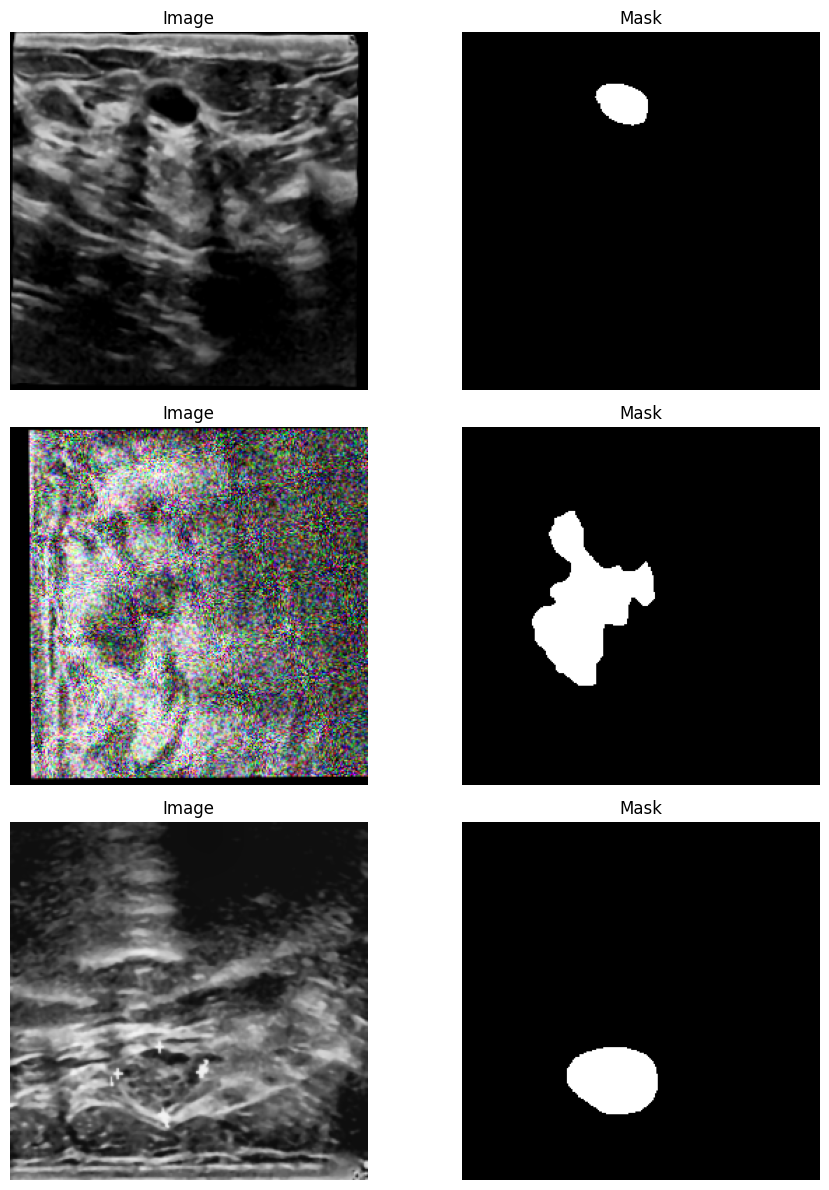

In [2]:
dataset_path = '../data/busi_dataset/Dataset_BUSI_with_GT'

data = load_busi_data(dataset_path)
busi_train_loader = data['train_loader']
busi_val_loader = data['val_loader']
busi_test_loader = data['test_loader']

data['visualize_samples'](data['train_dataset'])

In [3]:
models = {
    'unet_standard': UNet(n_channels=3, n_classes=1).to(device),
    'unet_with_depthwise': EnhancedUNet(n_channels=3, n_classes=1, use_se=False, use_lightweight=True).to(device),
    'unet_with_se_depthwise': EnhancedUNet(n_channels=3, n_classes=1, use_se=True, use_lightweight=True).to(device),
    'unet_with_se_depthwise_reduced': EnhancedUNet(n_channels=3, n_classes=1, use_se=True, use_lightweight=True, se_reduction=32).to(device),
    'unet_with_spatial_attn': SpatialAttentionUNet(n_channels=3, n_classes=1, use_se=True, use_lightweight=True).to(device),
}

for model_name, model in models.items():
    print(f"\n{model_name} summary:")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


unet_standard summary:
Total parameters: 31,037,633

unet_with_depthwise summary:
Total parameters: 5,988,252

unet_with_se_depthwise summary:
Total parameters: 6,206,364

unet_with_se_depthwise_reduced summary:
Total parameters: 6,097,308

unet_with_spatial_attn summary:
Total parameters: 6,206,756


In [4]:
def train_busi_model(model, model_name, train_loader, val_loader, num_epochs=30, 
                     model_dir="../saved_models/busi/", force_train=False, resume_training=True):
    """
    Training function for BUSI dataset - mostly the same as train_isic_model but with 
    BUSI-specific adjustments like directory paths
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    save_dir = os.path.join(model_dir, model_name)
    best_model_path = os.path.join(save_dir, 'best_model.pth')
    checkpoint_path = os.path.join(save_dir, 'checkpoint.pth')
    
    criterion = BCEDiceLoss()
    # Ultrasound images might need a higher learning rate
    optimizer = optim.Adam(model.parameters(), lr=2e-4)  
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=10,
        T_mult=2,
        eta_min=1e-6
    )
    
    # Initialize metrics tracking
    train_losses = []
    val_losses = []
    val_dices = []
    val_ious = []
    learning_rates = []
    best_val_dice = 0
    start_epoch = 0
    
    if os.path.exists(checkpoint_path) and resume_training and not force_train:
        print(f"Loading checkpoint from {checkpoint_path} to resume training.")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_dice = checkpoint['val_dice']
        
        # If metrics history is saved in checkpoint, load them
        if 'train_losses' in checkpoint:
            train_losses = checkpoint['train_losses']
            val_losses = checkpoint['val_losses']
            val_dices = checkpoint['val_dices']
            val_ious = checkpoint.get('val_ious', [])
            learning_rates = checkpoint.get('learning_rates', [])
        
        print(f"Resuming from epoch {start_epoch} with best validation Dice: {best_val_dice:.4f}")
    
    # Check if best model exists
    elif os.path.exists(best_model_path) and not force_train:
        print(f"Found existing model at {best_model_path}. Skipping training.")
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        
        # Evaluate the loaded model on validation set
        model.eval()
        epoch_dice = 0
        epoch_iou = 0
        batch_count = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                dice = dice_coefficient(outputs, masks)
                iou = iou_coefficient(outputs, masks)
                
                epoch_dice += dice
                epoch_iou += iou
                batch_count += 1
        
        val_dice = epoch_dice / batch_count
        val_iou = epoch_iou / batch_count
        
        print(f"Loaded model performance - Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")
        
        return {
            'model': model,
            'best_val_dice': val_dice,
            'loaded_from_checkpoint': True
        }
    
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    
    # Training loop
    for epoch in range(start_epoch, num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Training phase
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
            
            if batch_count % 10 == 0:
                del images, masks, outputs, loss
                torch.cuda.empty_cache()
        
        train_loss = epoch_loss / batch_count
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        epoch_loss = 0
        epoch_dice = 0
        epoch_iou = 0
        batch_count = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                dice = dice_coefficient(outputs, masks)
                iou = iou_coefficient(outputs, masks)
                
                epoch_loss += loss.item()
                epoch_dice += dice
                epoch_iou += iou
                batch_count += 1
                
                del images, masks, outputs, loss
        
        val_loss = epoch_loss / batch_count
        val_dice = epoch_dice / batch_count
        val_iou = epoch_iou / batch_count
        
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        val_ious.append(val_iou)
        
        scheduler.step(val_loss)
        
        # Print progress
        print(f'Epoch {epoch+1:3d}/{num_epochs} | LR: {current_lr:.6f} | '
              f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
              f'Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}')
        
        # Save checkpoint every epoch for resuming
        os.makedirs(save_dir, exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_dice': val_dice,
            'val_loss': val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_dices': val_dices,
            'val_ious': val_ious,
            'learning_rates': learning_rates,
            'best_val_dice': best_val_dice
        }, os.path.join(save_dir, 'checkpoint.pth'))
        
        # Save best model based on Dice coefficient
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"Saved new best model with Dice score: {val_dice:.4f}")
        
        # Memory cleanup after each epoch
        gc.collect()
        torch.cuda.empty_cache()
    
    # Save final model
    torch.save(model.state_dict(), os.path.join(save_dir, 'final_model.pth'))
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_dices': val_dices,
        'val_ious': val_ious,
        'learning_rates': learning_rates,
        'best_val_dice': best_val_dice,
        'epochs': num_epochs,
        'loaded_from_checkpoint': False
    }


In [6]:
num_epochs = 75
busi_results = {}

# Clear memory before starting training loop
gc.collect()
torch.cuda.empty_cache()

for model_name, model in models.items():
    print(f"\n{'='*20} Training {model_name} model on BUSI {'='*20}")
    try:
        model_results = train_busi_model(
            model, 
            model_name, 
            busi_train_loader, 
            busi_val_loader, 
            num_epochs=num_epochs,
            resume_training=True,
        )
        busi_results[model_name] = model_results
        print(f"Completed training for {model_name} model on BUSI dataset")
        
    except Exception as e:
        print(f"Error training {model_name}: {e}")
        continue
        
    gc.collect()
    torch.cuda.empty_cache()
    
# Save all results to file
import json
import os

os.makedirs('results', exist_ok=True)
with open('results/busi_training_results.json', 'w') as f:
    serializable_results = {}
    for model_name, results in busi_results.items():
        if isinstance(results, dict):
            serializable_model_results = {}
            for k, v in results.items():
                if isinstance(v, (list, dict, str, int, float, bool)) or v is None:
                    serializable_model_results[k] = v
                elif hasattr(v, 'tolist'):
                    try:
                        serializable_model_results[k] = v.tolist()
                    except:
                        serializable_model_results[k] = str(v)
                else:
                    serializable_model_results[k] = str(v)
            serializable_results[model_name] = serializable_model_results
    
    json.dump(serializable_results, f, indent=2)


==================== Training unet_standard model on BUSI ====================
Loading checkpoint from ../saved_models/busi/unet_standard/checkpoint.pth to resume training.
Resuming from epoch 1 with best validation Dice: 0.2227


Epoch   2/75 | LR: 0.000191 | Train Loss: 1.1591 | Val Loss: 1.1400 | Val Dice: 0.1563 | Val IoU: 0.0874


Epoch   3/75 | LR: 0.000194 | Train Loss: 1.0418 | Val Loss: 1.1000 | Val Dice: 0.3614 | Val IoU: 0.2292
Saved new best model with Dice score: 0.3614


Epoch   4/75 | LR: 0.000194 | Train Loss: 0.9765 | Val Loss: 0.9949 | Val Dice: 0.3808 | Val IoU: 0.2423
Saved new best model with Dice score: 0.3808


Epoch   5/75 | LR: 0.000195 | Train Loss: 0.9105 | Val Loss: 1.0054 | Val Dice: 0.4202 | Val IoU: 0.2777
Saved new best model with Dice score: 0.4202


Epoch   6/75 | LR: 0.000195 | Train Loss: 0.8859 | Val Loss: 0.9691 | Val Dice: 0.4190 | Val IoU: 0.2711


Epoch   7/75 | LR: 0.000195 | Train Loss: 0.8516 | Val Loss: 1.0157 | Val Dice: 0.4148 | Val IoU: 0.2728


Epoch   8/75 | LR: 0.000195 | Train Loss: 0.8305 | Val Loss: 1.2131 | Val Dice: 0.3813 | Val IoU: 0.2457


Epoch   9/75 | LR: 0.000193 | Train Loss: 0.8202 | Val Loss: 0.8451 | Val Dice: 0.4688 | Val IoU: 0.3228
Saved new best model with Dice score: 0.4688


Epoch  10/75 | LR: 0.000197 | Train Loss: 0.7928 | Val Loss: 0.9380 | Val Dice: 0.3946 | Val IoU: 0.2629


Epoch  11/75 | LR: 0.000196 | Train Loss: 0.7763 | Val Loss: 0.9119 | Val Dice: 0.4757 | Val IoU: 0.3249
Saved new best model with Dice score: 0.4757


Epoch  12/75 | LR: 0.000196 | Train Loss: 0.7754 | Val Loss: 0.8055 | Val Dice: 0.5118 | Val IoU: 0.3547
Saved new best model with Dice score: 0.5118


Epoch  13/75 | LR: 0.000197 | Train Loss: 0.7277 | Val Loss: 0.7345 | Val Dice: 0.5511 | Val IoU: 0.4067
Saved new best model with Dice score: 0.5511


Epoch  14/75 | LR: 0.000197 | Train Loss: 0.7369 | Val Loss: 0.8073 | Val Dice: 0.5176 | Val IoU: 0.3611


Epoch  15/75 | LR: 0.000197 | Train Loss: 0.7398 | Val Loss: 0.7118 | Val Dice: 0.5782 | Val IoU: 0.4296
Saved new best model with Dice score: 0.5782


Epoch  16/75 | LR: 0.000198 | Train Loss: 0.7275 | Val Loss: 0.8070 | Val Dice: 0.5492 | Val IoU: 0.4035


Epoch  17/75 | LR: 0.000197 | Train Loss: 0.7201 | Val Loss: 0.6503 | Val Dice: 0.6097 | Val IoU: 0.4536
Saved new best model with Dice score: 0.6097


Epoch  18/75 | LR: 0.000198 | Train Loss: 0.7145 | Val Loss: 0.6747 | Val Dice: 0.5928 | Val IoU: 0.4386


Epoch  19/75 | LR: 0.000198 | Train Loss: 0.7014 | Val Loss: 0.6725 | Val Dice: 0.6031 | Val IoU: 0.4455


Epoch  20/75 | LR: 0.000198 | Train Loss: 0.6974 | Val Loss: 0.6614 | Val Dice: 0.6068 | Val IoU: 0.4549


Epoch  21/75 | LR: 0.000198 | Train Loss: 0.6740 | Val Loss: 0.6592 | Val Dice: 0.6080 | Val IoU: 0.4633


Epoch  22/75 | LR: 0.000198 | Train Loss: 0.6824 | Val Loss: 0.7028 | Val Dice: 0.5717 | Val IoU: 0.4151


Epoch  23/75 | LR: 0.000198 | Train Loss: 0.6652 | Val Loss: 0.6819 | Val Dice: 0.6077 | Val IoU: 0.4584


Epoch  24/75 | LR: 0.000198 | Train Loss: 0.6980 | Val Loss: 0.6561 | Val Dice: 0.6195 | Val IoU: 0.4664
Saved new best model with Dice score: 0.6195


Epoch  25/75 | LR: 0.000198 | Train Loss: 0.6653 | Val Loss: 0.6226 | Val Dice: 0.6295 | Val IoU: 0.4775
Saved new best model with Dice score: 0.6295


Epoch  26/75 | LR: 0.000198 | Train Loss: 0.6434 | Val Loss: 0.5874 | Val Dice: 0.6582 | Val IoU: 0.5053
Saved new best model with Dice score: 0.6582


Epoch  27/75 | LR: 0.000198 | Train Loss: 0.6459 | Val Loss: 0.6027 | Val Dice: 0.6470 | Val IoU: 0.4954


Epoch  28/75 | LR: 0.000198 | Train Loss: 0.6768 | Val Loss: 0.6791 | Val Dice: 0.6221 | Val IoU: 0.4760


Epoch  29/75 | LR: 0.000198 | Train Loss: 0.6672 | Val Loss: 0.6312 | Val Dice: 0.6422 | Val IoU: 0.4961


Epoch  30/75 | LR: 0.000198 | Train Loss: 0.6587 | Val Loss: 0.6335 | Val Dice: 0.6276 | Val IoU: 0.4795


Epoch  31/75 | LR: 0.000198 | Train Loss: 0.6622 | Val Loss: 0.6544 | Val Dice: 0.6316 | Val IoU: 0.4854


Epoch  32/75 | LR: 0.000198 | Train Loss: 0.6373 | Val Loss: 0.6998 | Val Dice: 0.5731 | Val IoU: 0.4190


Epoch  33/75 | LR: 0.000198 | Train Loss: 0.6557 | Val Loss: 0.5892 | Val Dice: 0.6587 | Val IoU: 0.5086
Saved new best model with Dice score: 0.6587


Epoch  34/75 | LR: 0.000198 | Train Loss: 0.6348 | Val Loss: 0.5754 | Val Dice: 0.6618 | Val IoU: 0.5162
Saved new best model with Dice score: 0.6618


Epoch  35/75 | LR: 0.000198 | Train Loss: 0.6488 | Val Loss: 0.6290 | Val Dice: 0.6178 | Val IoU: 0.4704


Epoch  36/75 | LR: 0.000198 | Train Loss: 0.6377 | Val Loss: 0.6235 | Val Dice: 0.6386 | Val IoU: 0.4947


Epoch  37/75 | LR: 0.000198 | Train Loss: 0.6041 | Val Loss: 0.6486 | Val Dice: 0.6214 | Val IoU: 0.4633


Epoch  38/75 | LR: 0.000198 | Train Loss: 0.6341 | Val Loss: 0.6634 | Val Dice: 0.6133 | Val IoU: 0.4621


Epoch  39/75 | LR: 0.000198 | Train Loss: 0.5995 | Val Loss: 0.5584 | Val Dice: 0.6745 | Val IoU: 0.5247
Saved new best model with Dice score: 0.6745


Epoch  40/75 | LR: 0.000198 | Train Loss: 0.6143 | Val Loss: 0.5808 | Val Dice: 0.6547 | Val IoU: 0.5101


Epoch  41/75 | LR: 0.000198 | Train Loss: 0.6054 | Val Loss: 0.5426 | Val Dice: 0.6865 | Val IoU: 0.5410
Saved new best model with Dice score: 0.6865


Epoch  42/75 | LR: 0.000199 | Train Loss: 0.6266 | Val Loss: 0.5716 | Val Dice: 0.6642 | Val IoU: 0.5114


Epoch  43/75 | LR: 0.000198 | Train Loss: 0.5961 | Val Loss: 0.5598 | Val Dice: 0.6662 | Val IoU: 0.5200


Epoch  44/75 | LR: 0.000198 | Train Loss: 0.5900 | Val Loss: 0.5656 | Val Dice: 0.6763 | Val IoU: 0.5303


Epoch  45/75 | LR: 0.000198 | Train Loss: 0.5991 | Val Loss: 0.6239 | Val Dice: 0.6273 | Val IoU: 0.4826


Epoch  46/75 | LR: 0.000198 | Train Loss: 0.6063 | Val Loss: 0.5577 | Val Dice: 0.6750 | Val IoU: 0.5330


Epoch  47/75 | LR: 0.000198 | Train Loss: 0.5905 | Val Loss: 0.5035 | Val Dice: 0.7073 | Val IoU: 0.5622
Saved new best model with Dice score: 0.7073


Epoch  48/75 | LR: 0.000199 | Train Loss: 0.5761 | Val Loss: 0.5668 | Val Dice: 0.6708 | Val IoU: 0.5203


Epoch  49/75 | LR: 0.000198 | Train Loss: 0.5997 | Val Loss: 0.5538 | Val Dice: 0.6692 | Val IoU: 0.5237


Epoch  50/75 | LR: 0.000198 | Train Loss: 0.5992 | Val Loss: 0.5569 | Val Dice: 0.6757 | Val IoU: 0.5234


Epoch  51/75 | LR: 0.000198 | Train Loss: 0.5865 | Val Loss: 0.5224 | Val Dice: 0.6963 | Val IoU: 0.5510


Epoch  52/75 | LR: 0.000199 | Train Loss: 0.5720 | Val Loss: 0.6552 | Val Dice: 0.6171 | Val IoU: 0.4674


Epoch  53/75 | LR: 0.000198 | Train Loss: 0.5676 | Val Loss: 0.5203 | Val Dice: 0.6974 | Val IoU: 0.5542


Epoch  54/75 | LR: 0.000199 | Train Loss: 0.5738 | Val Loss: 0.5064 | Val Dice: 0.7087 | Val IoU: 0.5654
Saved new best model with Dice score: 0.7087


Epoch  55/75 | LR: 0.000199 | Train Loss: 0.5799 | Val Loss: 0.5641 | Val Dice: 0.6825 | Val IoU: 0.5336


Epoch  56/75 | LR: 0.000198 | Train Loss: 0.5678 | Val Loss: 0.4880 | Val Dice: 0.7152 | Val IoU: 0.5729
Saved new best model with Dice score: 0.7152


Epoch  57/75 | LR: 0.000199 | Train Loss: 0.5598 | Val Loss: 0.5189 | Val Dice: 0.6989 | Val IoU: 0.5539


Epoch  58/75 | LR: 0.000199 | Train Loss: 0.5650 | Val Loss: 0.5276 | Val Dice: 0.6999 | Val IoU: 0.5543


Epoch  59/75 | LR: 0.000199 | Train Loss: 0.5702 | Val Loss: 0.6538 | Val Dice: 0.6541 | Val IoU: 0.5050


Epoch  60/75 | LR: 0.000198 | Train Loss: 0.5681 | Val Loss: 0.5557 | Val Dice: 0.6706 | Val IoU: 0.5219


Epoch  61/75 | LR: 0.000198 | Train Loss: 0.5660 | Val Loss: 0.5449 | Val Dice: 0.6797 | Val IoU: 0.5313


Epoch  62/75 | LR: 0.000199 | Train Loss: 0.5631 | Val Loss: 0.5631 | Val Dice: 0.6691 | Val IoU: 0.5243


Epoch  63/75 | LR: 0.000198 | Train Loss: 0.5660 | Val Loss: 0.5559 | Val Dice: 0.6871 | Val IoU: 0.5369


Epoch  64/75 | LR: 0.000198 | Train Loss: 0.5577 | Val Loss: 0.4820 | Val Dice: 0.7197 | Val IoU: 0.5768
Saved new best model with Dice score: 0.7197


Epoch  65/75 | LR: 0.000199 | Train Loss: 0.5541 | Val Loss: 0.5505 | Val Dice: 0.6747 | Val IoU: 0.5285


Epoch  66/75 | LR: 0.000199 | Train Loss: 0.5698 | Val Loss: 0.6034 | Val Dice: 0.6644 | Val IoU: 0.5200


Epoch  67/75 | LR: 0.000198 | Train Loss: 0.5316 | Val Loss: 0.5310 | Val Dice: 0.6886 | Val IoU: 0.5454


Epoch  68/75 | LR: 0.000199 | Train Loss: 0.5418 | Val Loss: 0.4854 | Val Dice: 0.7216 | Val IoU: 0.5864
Saved new best model with Dice score: 0.7216


Epoch  69/75 | LR: 0.000199 | Train Loss: 0.5584 | Val Loss: 0.5411 | Val Dice: 0.6933 | Val IoU: 0.5499


Epoch  70/75 | LR: 0.000199 | Train Loss: 0.5538 | Val Loss: 0.5084 | Val Dice: 0.6965 | Val IoU: 0.5558


Epoch  71/75 | LR: 0.000199 | Train Loss: 0.5461 | Val Loss: 0.5129 | Val Dice: 0.7115 | Val IoU: 0.5656


Epoch  72/75 | LR: 0.000199 | Train Loss: 0.5310 | Val Loss: 0.5186 | Val Dice: 0.7047 | Val IoU: 0.5651


Epoch  73/75 | LR: 0.000199 | Train Loss: 0.5618 | Val Loss: 0.5310 | Val Dice: 0.6874 | Val IoU: 0.5435


Epoch  74/75 | LR: 0.000199 | Train Loss: 0.5254 | Val Loss: 0.5180 | Val Dice: 0.6943 | Val IoU: 0.5546


Epoch  75/75 | LR: 0.000199 | Train Loss: 0.5271 | Val Loss: 0.4906 | Val Dice: 0.7152 | Val IoU: 0.5731
Completed training for unet_standard model on BUSI dataset

==================== Training unet_with_depthwise model on BUSI ====================


Epoch   1/75 | LR: 0.000200 | Train Loss: 1.3315 | Val Loss: 1.1476 | Val Dice: 0.4106 | Val IoU: 0.2687
Saved new best model with Dice score: 0.4106


Epoch   2/75 | LR: 0.000194 | Train Loss: 1.0539 | Val Loss: 0.9135 | Val Dice: 0.5335 | Val IoU: 0.3748
Saved new best model with Dice score: 0.5335


Epoch   3/75 | LR: 0.000196 | Train Loss: 0.9355 | Val Loss: 0.8550 | Val Dice: 0.5406 | Val IoU: 0.3818
Saved new best model with Dice score: 0.5406


Epoch   4/75 | LR: 0.000196 | Train Loss: 0.8657 | Val Loss: 0.8194 | Val Dice: 0.5571 | Val IoU: 0.4045
Saved new best model with Dice score: 0.5571


Epoch   5/75 | LR: 0.000197 | Train Loss: 0.8003 | Val Loss: 0.7592 | Val Dice: 0.5699 | Val IoU: 0.4168
Saved new best model with Dice score: 0.5699


Epoch   6/75 | LR: 0.000197 | Train Loss: 0.7612 | Val Loss: 0.7165 | Val Dice: 0.5856 | Val IoU: 0.4312
Saved new best model with Dice score: 0.5856


Epoch   7/75 | LR: 0.000197 | Train Loss: 0.7530 | Val Loss: 0.7350 | Val Dice: 0.5689 | Val IoU: 0.4178


Epoch   8/75 | LR: 0.000197 | Train Loss: 0.7018 | Val Loss: 0.6969 | Val Dice: 0.6003 | Val IoU: 0.4435
Saved new best model with Dice score: 0.6003


Epoch   9/75 | LR: 0.000198 | Train Loss: 0.6856 | Val Loss: 0.6703 | Val Dice: 0.6112 | Val IoU: 0.4585
Saved new best model with Dice score: 0.6112


Epoch  10/75 | LR: 0.000198 | Train Loss: 0.6763 | Val Loss: 0.6232 | Val Dice: 0.6396 | Val IoU: 0.4861
Saved new best model with Dice score: 0.6396


Epoch  11/75 | LR: 0.000198 | Train Loss: 0.6611 | Val Loss: 0.5954 | Val Dice: 0.6565 | Val IoU: 0.5041
Saved new best model with Dice score: 0.6565


Epoch  12/75 | LR: 0.000198 | Train Loss: 0.6626 | Val Loss: 0.6687 | Val Dice: 0.6284 | Val IoU: 0.4815


Epoch  13/75 | LR: 0.000198 | Train Loss: 0.6387 | Val Loss: 0.5751 | Val Dice: 0.6668 | Val IoU: 0.5164
Saved new best model with Dice score: 0.6668


Epoch  14/75 | LR: 0.000198 | Train Loss: 0.6385 | Val Loss: 0.6030 | Val Dice: 0.6333 | Val IoU: 0.4854


Epoch  15/75 | LR: 0.000198 | Train Loss: 0.6167 | Val Loss: 0.5591 | Val Dice: 0.6627 | Val IoU: 0.5160


Epoch  16/75 | LR: 0.000198 | Train Loss: 0.6024 | Val Loss: 0.5961 | Val Dice: 0.6553 | Val IoU: 0.5030


Epoch  17/75 | LR: 0.000198 | Train Loss: 0.6092 | Val Loss: 0.5529 | Val Dice: 0.6834 | Val IoU: 0.5373
Saved new best model with Dice score: 0.6834


Epoch  18/75 | LR: 0.000199 | Train Loss: 0.5971 | Val Loss: 0.5586 | Val Dice: 0.6705 | Val IoU: 0.5309


Epoch  19/75 | LR: 0.000198 | Train Loss: 0.5902 | Val Loss: 0.5445 | Val Dice: 0.6903 | Val IoU: 0.5465
Saved new best model with Dice score: 0.6903


Epoch  20/75 | LR: 0.000199 | Train Loss: 0.5898 | Val Loss: 0.5361 | Val Dice: 0.6922 | Val IoU: 0.5512
Saved new best model with Dice score: 0.6922


Epoch  21/75 | LR: 0.000199 | Train Loss: 0.5768 | Val Loss: 0.5323 | Val Dice: 0.6918 | Val IoU: 0.5429


Epoch  22/75 | LR: 0.000199 | Train Loss: 0.5665 | Val Loss: 0.4883 | Val Dice: 0.7167 | Val IoU: 0.5733
Saved new best model with Dice score: 0.7167


Epoch  23/75 | LR: 0.000199 | Train Loss: 0.5651 | Val Loss: 0.5235 | Val Dice: 0.6956 | Val IoU: 0.5566


Epoch  24/75 | LR: 0.000199 | Train Loss: 0.5753 | Val Loss: 0.5235 | Val Dice: 0.6991 | Val IoU: 0.5565


Epoch  25/75 | LR: 0.000199 | Train Loss: 0.5440 | Val Loss: 0.6035 | Val Dice: 0.6527 | Val IoU: 0.5008


Epoch  26/75 | LR: 0.000198 | Train Loss: 0.5528 | Val Loss: 0.5301 | Val Dice: 0.6905 | Val IoU: 0.5471


Epoch  27/75 | LR: 0.000199 | Train Loss: 0.5628 | Val Loss: 0.5199 | Val Dice: 0.7093 | Val IoU: 0.5631


Epoch  28/75 | LR: 0.000199 | Train Loss: 0.5345 | Val Loss: 0.5194 | Val Dice: 0.7085 | Val IoU: 0.5694


Epoch  29/75 | LR: 0.000199 | Train Loss: 0.5517 | Val Loss: 0.5514 | Val Dice: 0.6946 | Val IoU: 0.5525


Epoch  30/75 | LR: 0.000199 | Train Loss: 0.5313 | Val Loss: 0.5191 | Val Dice: 0.7057 | Val IoU: 0.5657


Epoch  31/75 | LR: 0.000199 | Train Loss: 0.5334 | Val Loss: 0.4894 | Val Dice: 0.7187 | Val IoU: 0.5771
Saved new best model with Dice score: 0.7187


Epoch  32/75 | LR: 0.000199 | Train Loss: 0.5224 | Val Loss: 0.5621 | Val Dice: 0.6709 | Val IoU: 0.5308


Epoch  33/75 | LR: 0.000198 | Train Loss: 0.5297 | Val Loss: 0.5131 | Val Dice: 0.6995 | Val IoU: 0.5578


Epoch  34/75 | LR: 0.000199 | Train Loss: 0.5191 | Val Loss: 0.4991 | Val Dice: 0.7090 | Val IoU: 0.5681


Epoch  35/75 | LR: 0.000199 | Train Loss: 0.5113 | Val Loss: 0.5078 | Val Dice: 0.7105 | Val IoU: 0.5728


Epoch  36/75 | LR: 0.000199 | Train Loss: 0.5144 | Val Loss: 0.4560 | Val Dice: 0.7430 | Val IoU: 0.6070
Saved new best model with Dice score: 0.7430


Epoch  37/75 | LR: 0.000199 | Train Loss: 0.4972 | Val Loss: 0.5249 | Val Dice: 0.7115 | Val IoU: 0.5702


Epoch  38/75 | LR: 0.000199 | Train Loss: 0.4983 | Val Loss: 0.5124 | Val Dice: 0.7056 | Val IoU: 0.5617


Epoch  39/75 | LR: 0.000199 | Train Loss: 0.4915 | Val Loss: 0.4798 | Val Dice: 0.7310 | Val IoU: 0.5925


Epoch  40/75 | LR: 0.000199 | Train Loss: 0.4764 | Val Loss: 0.4709 | Val Dice: 0.7338 | Val IoU: 0.5983


Epoch  41/75 | LR: 0.000199 | Train Loss: 0.4908 | Val Loss: 0.5184 | Val Dice: 0.7002 | Val IoU: 0.5629


Epoch  42/75 | LR: 0.000199 | Train Loss: 0.4734 | Val Loss: 0.5158 | Val Dice: 0.7083 | Val IoU: 0.5645


Epoch  43/75 | LR: 0.000199 | Train Loss: 0.4897 | Val Loss: 0.5476 | Val Dice: 0.6981 | Val IoU: 0.5585


Epoch  44/75 | LR: 0.000199 | Train Loss: 0.4819 | Val Loss: 0.4833 | Val Dice: 0.7283 | Val IoU: 0.5906


Epoch  45/75 | LR: 0.000199 | Train Loss: 0.4751 | Val Loss: 0.5065 | Val Dice: 0.7185 | Val IoU: 0.5822


Epoch  46/75 | LR: 0.000199 | Train Loss: 0.4617 | Val Loss: 0.4646 | Val Dice: 0.7383 | Val IoU: 0.6017


Epoch  47/75 | LR: 0.000199 | Train Loss: 0.4565 | Val Loss: 0.5420 | Val Dice: 0.7049 | Val IoU: 0.5714


Epoch  48/75 | LR: 0.000199 | Train Loss: 0.4666 | Val Loss: 0.5419 | Val Dice: 0.6852 | Val IoU: 0.5438


Epoch  49/75 | LR: 0.000199 | Train Loss: 0.4531 | Val Loss: 0.4840 | Val Dice: 0.7243 | Val IoU: 0.5820


Epoch  50/75 | LR: 0.000199 | Train Loss: 0.4423 | Val Loss: 0.5197 | Val Dice: 0.7207 | Val IoU: 0.5850


Epoch  51/75 | LR: 0.000199 | Train Loss: 0.4428 | Val Loss: 0.5932 | Val Dice: 0.6603 | Val IoU: 0.5243


Epoch  52/75 | LR: 0.000198 | Train Loss: 0.4543 | Val Loss: 0.5583 | Val Dice: 0.6887 | Val IoU: 0.5463


Epoch  53/75 | LR: 0.000198 | Train Loss: 0.4464 | Val Loss: 0.5380 | Val Dice: 0.7004 | Val IoU: 0.5669


Epoch  54/75 | LR: 0.000199 | Train Loss: 0.4378 | Val Loss: 0.4879 | Val Dice: 0.7231 | Val IoU: 0.5837


Epoch  55/75 | LR: 0.000199 | Train Loss: 0.4495 | Val Loss: 0.5835 | Val Dice: 0.6880 | Val IoU: 0.5462


Epoch  56/75 | LR: 0.000198 | Train Loss: 0.4353 | Val Loss: 0.5283 | Val Dice: 0.7158 | Val IoU: 0.5869


Epoch  57/75 | LR: 0.000199 | Train Loss: 0.4309 | Val Loss: 0.4582 | Val Dice: 0.7395 | Val IoU: 0.6031


Epoch  58/75 | LR: 0.000199 | Train Loss: 0.4295 | Val Loss: 0.4666 | Val Dice: 0.7365 | Val IoU: 0.5994


Epoch  59/75 | LR: 0.000199 | Train Loss: 0.4463 | Val Loss: 0.5455 | Val Dice: 0.6959 | Val IoU: 0.5631


Epoch  60/75 | LR: 0.000199 | Train Loss: 0.4352 | Val Loss: 0.4678 | Val Dice: 0.7311 | Val IoU: 0.5943


Epoch  61/75 | LR: 0.000199 | Train Loss: 0.4288 | Val Loss: 0.4616 | Val Dice: 0.7373 | Val IoU: 0.5976


Epoch  62/75 | LR: 0.000199 | Train Loss: 0.4035 | Val Loss: 0.4804 | Val Dice: 0.7209 | Val IoU: 0.5783


Epoch  63/75 | LR: 0.000199 | Train Loss: 0.4301 | Val Loss: 0.4610 | Val Dice: 0.7329 | Val IoU: 0.5941


Epoch  64/75 | LR: 0.000199 | Train Loss: 0.4021 | Val Loss: 0.5233 | Val Dice: 0.7162 | Val IoU: 0.5820


Epoch  65/75 | LR: 0.000199 | Train Loss: 0.4184 | Val Loss: 0.4182 | Val Dice: 0.7633 | Val IoU: 0.6317
Saved new best model with Dice score: 0.7633


Epoch  66/75 | LR: 0.000199 | Train Loss: 0.4005 | Val Loss: 0.4435 | Val Dice: 0.7484 | Val IoU: 0.6133


Epoch  67/75 | LR: 0.000199 | Train Loss: 0.3956 | Val Loss: 0.4494 | Val Dice: 0.7455 | Val IoU: 0.6097


Epoch  68/75 | LR: 0.000199 | Train Loss: 0.4148 | Val Loss: 0.5212 | Val Dice: 0.7051 | Val IoU: 0.5661


Epoch  69/75 | LR: 0.000199 | Train Loss: 0.4076 | Val Loss: 0.5098 | Val Dice: 0.7202 | Val IoU: 0.5799


Epoch  70/75 | LR: 0.000199 | Train Loss: 0.4002 | Val Loss: 0.5372 | Val Dice: 0.6940 | Val IoU: 0.5531


Epoch  71/75 | LR: 0.000199 | Train Loss: 0.4142 | Val Loss: 0.5251 | Val Dice: 0.6973 | Val IoU: 0.5549


Epoch  72/75 | LR: 0.000199 | Train Loss: 0.3961 | Val Loss: 0.4866 | Val Dice: 0.7212 | Val IoU: 0.5823


Epoch  73/75 | LR: 0.000199 | Train Loss: 0.4089 | Val Loss: 0.4562 | Val Dice: 0.7505 | Val IoU: 0.6164


Epoch  74/75 | LR: 0.000199 | Train Loss: 0.3752 | Val Loss: 0.5782 | Val Dice: 0.6927 | Val IoU: 0.5569


Epoch  75/75 | LR: 0.000198 | Train Loss: 0.3949 | Val Loss: 0.4553 | Val Dice: 0.7480 | Val IoU: 0.6140
Completed training for unet_with_depthwise model on BUSI dataset

==================== Training unet_with_se_depthwise model on BUSI ====================


Epoch   1/75 | LR: 0.000200 | Train Loss: 1.3674 | Val Loss: 1.1457 | Val Dice: 0.5116 | Val IoU: 0.3522
Saved new best model with Dice score: 0.5116


Epoch   2/75 | LR: 0.000194 | Train Loss: 1.1206 | Val Loss: 1.0467 | Val Dice: 0.5005 | Val IoU: 0.3456


Epoch   3/75 | LR: 0.000195 | Train Loss: 0.9760 | Val Loss: 0.8371 | Val Dice: 0.5921 | Val IoU: 0.4351
Saved new best model with Dice score: 0.5921


Epoch   4/75 | LR: 0.000197 | Train Loss: 0.8642 | Val Loss: 0.7680 | Val Dice: 0.6083 | Val IoU: 0.4482
Saved new best model with Dice score: 0.6083


Epoch   5/75 | LR: 0.000197 | Train Loss: 0.7723 | Val Loss: 0.6738 | Val Dice: 0.6354 | Val IoU: 0.4788
Saved new best model with Dice score: 0.6354


Epoch   6/75 | LR: 0.000198 | Train Loss: 0.7176 | Val Loss: 0.6129 | Val Dice: 0.6554 | Val IoU: 0.5022
Saved new best model with Dice score: 0.6554


Epoch   7/75 | LR: 0.000198 | Train Loss: 0.6762 | Val Loss: 0.5945 | Val Dice: 0.6586 | Val IoU: 0.5073
Saved new best model with Dice score: 0.6586


Epoch   8/75 | LR: 0.000198 | Train Loss: 0.6550 | Val Loss: 0.6089 | Val Dice: 0.6525 | Val IoU: 0.4995


Epoch   9/75 | LR: 0.000198 | Train Loss: 0.6067 | Val Loss: 0.5034 | Val Dice: 0.7051 | Val IoU: 0.5611
Saved new best model with Dice score: 0.7051


Epoch  10/75 | LR: 0.000199 | Train Loss: 0.6090 | Val Loss: 0.5320 | Val Dice: 0.6792 | Val IoU: 0.5273


Epoch  11/75 | LR: 0.000199 | Train Loss: 0.5973 | Val Loss: 0.5382 | Val Dice: 0.6825 | Val IoU: 0.5351


Epoch  12/75 | LR: 0.000199 | Train Loss: 0.6014 | Val Loss: 0.4766 | Val Dice: 0.7144 | Val IoU: 0.5730
Saved new best model with Dice score: 0.7144


Epoch  13/75 | LR: 0.000199 | Train Loss: 0.5792 | Val Loss: 0.4934 | Val Dice: 0.7109 | Val IoU: 0.5706


Epoch  14/75 | LR: 0.000199 | Train Loss: 0.5463 | Val Loss: 0.4957 | Val Dice: 0.7089 | Val IoU: 0.5644


Epoch  15/75 | LR: 0.000199 | Train Loss: 0.5528 | Val Loss: 0.5179 | Val Dice: 0.6954 | Val IoU: 0.5525


Epoch  16/75 | LR: 0.000199 | Train Loss: 0.5395 | Val Loss: 0.4786 | Val Dice: 0.7148 | Val IoU: 0.5754
Saved new best model with Dice score: 0.7148


Epoch  17/75 | LR: 0.000199 | Train Loss: 0.5449 | Val Loss: 0.5168 | Val Dice: 0.6984 | Val IoU: 0.5521


Epoch  18/75 | LR: 0.000199 | Train Loss: 0.5243 | Val Loss: 0.4607 | Val Dice: 0.7269 | Val IoU: 0.5870
Saved new best model with Dice score: 0.7269


Epoch  19/75 | LR: 0.000199 | Train Loss: 0.5019 | Val Loss: 0.4615 | Val Dice: 0.7247 | Val IoU: 0.5869


Epoch  20/75 | LR: 0.000199 | Train Loss: 0.5224 | Val Loss: 0.4629 | Val Dice: 0.7188 | Val IoU: 0.5836


Epoch  21/75 | LR: 0.000199 | Train Loss: 0.4932 | Val Loss: 0.4389 | Val Dice: 0.7451 | Val IoU: 0.6061
Saved new best model with Dice score: 0.7451


Epoch  22/75 | LR: 0.000199 | Train Loss: 0.5059 | Val Loss: 0.4555 | Val Dice: 0.7314 | Val IoU: 0.5952


Epoch  23/75 | LR: 0.000199 | Train Loss: 0.5030 | Val Loss: 0.4863 | Val Dice: 0.7091 | Val IoU: 0.5651


Epoch  24/75 | LR: 0.000199 | Train Loss: 0.4738 | Val Loss: 0.4344 | Val Dice: 0.7500 | Val IoU: 0.6158
Saved new best model with Dice score: 0.7500


Epoch  25/75 | LR: 0.000199 | Train Loss: 0.4829 | Val Loss: 0.4430 | Val Dice: 0.7349 | Val IoU: 0.5985


Epoch  26/75 | LR: 0.000199 | Train Loss: 0.4784 | Val Loss: 0.4446 | Val Dice: 0.7329 | Val IoU: 0.5970


Epoch  27/75 | LR: 0.000199 | Train Loss: 0.4920 | Val Loss: 0.4205 | Val Dice: 0.7478 | Val IoU: 0.6127


Epoch  28/75 | LR: 0.000199 | Train Loss: 0.4773 | Val Loss: 0.4343 | Val Dice: 0.7446 | Val IoU: 0.6104


Epoch  29/75 | LR: 0.000199 | Train Loss: 0.4586 | Val Loss: 0.4500 | Val Dice: 0.7329 | Val IoU: 0.5964


Epoch  30/75 | LR: 0.000199 | Train Loss: 0.4601 | Val Loss: 0.4544 | Val Dice: 0.7253 | Val IoU: 0.5886


Epoch  31/75 | LR: 0.000199 | Train Loss: 0.4695 | Val Loss: 0.4414 | Val Dice: 0.7342 | Val IoU: 0.5961


Epoch  32/75 | LR: 0.000199 | Train Loss: 0.4382 | Val Loss: 0.4666 | Val Dice: 0.7202 | Val IoU: 0.5855


Epoch  33/75 | LR: 0.000199 | Train Loss: 0.4435 | Val Loss: 0.4073 | Val Dice: 0.7637 | Val IoU: 0.6327
Saved new best model with Dice score: 0.7637


Epoch  34/75 | LR: 0.000199 | Train Loss: 0.4437 | Val Loss: 0.4343 | Val Dice: 0.7496 | Val IoU: 0.6113


Epoch  35/75 | LR: 0.000199 | Train Loss: 0.4393 | Val Loss: 0.3967 | Val Dice: 0.7649 | Val IoU: 0.6373
Saved new best model with Dice score: 0.7649


Epoch  36/75 | LR: 0.000199 | Train Loss: 0.4088 | Val Loss: 0.4190 | Val Dice: 0.7541 | Val IoU: 0.6226


Epoch  37/75 | LR: 0.000199 | Train Loss: 0.4275 | Val Loss: 0.4424 | Val Dice: 0.7344 | Val IoU: 0.6005


Epoch  38/75 | LR: 0.000199 | Train Loss: 0.3922 | Val Loss: 0.4191 | Val Dice: 0.7517 | Val IoU: 0.6220


Epoch  39/75 | LR: 0.000199 | Train Loss: 0.4172 | Val Loss: 0.4127 | Val Dice: 0.7549 | Val IoU: 0.6222


Epoch  40/75 | LR: 0.000199 | Train Loss: 0.4276 | Val Loss: 0.3943 | Val Dice: 0.7690 | Val IoU: 0.6419
Saved new best model with Dice score: 0.7690


Epoch  41/75 | LR: 0.000199 | Train Loss: 0.4110 | Val Loss: 0.4090 | Val Dice: 0.7617 | Val IoU: 0.6316


Epoch  42/75 | LR: 0.000199 | Train Loss: 0.4219 | Val Loss: 0.4509 | Val Dice: 0.7320 | Val IoU: 0.5936


Epoch  43/75 | LR: 0.000199 | Train Loss: 0.4246 | Val Loss: 0.4365 | Val Dice: 0.7407 | Val IoU: 0.6092


Epoch  44/75 | LR: 0.000199 | Train Loss: 0.4078 | Val Loss: 0.4324 | Val Dice: 0.7384 | Val IoU: 0.6061


Epoch  45/75 | LR: 0.000199 | Train Loss: 0.4010 | Val Loss: 0.3987 | Val Dice: 0.7605 | Val IoU: 0.6306


Epoch  46/75 | LR: 0.000199 | Train Loss: 0.3895 | Val Loss: 0.3958 | Val Dice: 0.7657 | Val IoU: 0.6334


Epoch  47/75 | LR: 0.000199 | Train Loss: 0.3866 | Val Loss: 0.4025 | Val Dice: 0.7671 | Val IoU: 0.6364


Epoch  48/75 | LR: 0.000199 | Train Loss: 0.3827 | Val Loss: 0.4248 | Val Dice: 0.7499 | Val IoU: 0.6194


Epoch  49/75 | LR: 0.000199 | Train Loss: 0.3799 | Val Loss: 0.4468 | Val Dice: 0.7349 | Val IoU: 0.6055


Epoch  50/75 | LR: 0.000199 | Train Loss: 0.3803 | Val Loss: 0.4079 | Val Dice: 0.7586 | Val IoU: 0.6312


Epoch  51/75 | LR: 0.000199 | Train Loss: 0.3724 | Val Loss: 0.4140 | Val Dice: 0.7567 | Val IoU: 0.6297


Epoch  52/75 | LR: 0.000199 | Train Loss: 0.3781 | Val Loss: 0.4213 | Val Dice: 0.7553 | Val IoU: 0.6238


Epoch  53/75 | LR: 0.000199 | Train Loss: 0.3768 | Val Loss: 0.3813 | Val Dice: 0.7754 | Val IoU: 0.6536
Saved new best model with Dice score: 0.7754


Epoch  54/75 | LR: 0.000199 | Train Loss: 0.3752 | Val Loss: 0.4306 | Val Dice: 0.7476 | Val IoU: 0.6209


Epoch  55/75 | LR: 0.000199 | Train Loss: 0.3802 | Val Loss: 0.4393 | Val Dice: 0.7482 | Val IoU: 0.6188


Epoch  56/75 | LR: 0.000199 | Train Loss: 0.3627 | Val Loss: 0.3884 | Val Dice: 0.7645 | Val IoU: 0.6421


Epoch  57/75 | LR: 0.000199 | Train Loss: 0.3694 | Val Loss: 0.3828 | Val Dice: 0.7765 | Val IoU: 0.6536
Saved new best model with Dice score: 0.7765


Epoch  58/75 | LR: 0.000199 | Train Loss: 0.3700 | Val Loss: 0.4000 | Val Dice: 0.7689 | Val IoU: 0.6391


Epoch  59/75 | LR: 0.000199 | Train Loss: 0.3597 | Val Loss: 0.3860 | Val Dice: 0.7735 | Val IoU: 0.6472


Epoch  60/75 | LR: 0.000199 | Train Loss: 0.3651 | Val Loss: 0.4384 | Val Dice: 0.7457 | Val IoU: 0.6106


Epoch  61/75 | LR: 0.000199 | Train Loss: 0.3531 | Val Loss: 0.4105 | Val Dice: 0.7561 | Val IoU: 0.6283


Epoch  62/75 | LR: 0.000199 | Train Loss: 0.3410 | Val Loss: 0.4022 | Val Dice: 0.7658 | Val IoU: 0.6367


Epoch  63/75 | LR: 0.000199 | Train Loss: 0.3462 | Val Loss: 0.4081 | Val Dice: 0.7617 | Val IoU: 0.6309


Epoch  64/75 | LR: 0.000199 | Train Loss: 0.3376 | Val Loss: 0.4006 | Val Dice: 0.7627 | Val IoU: 0.6361


Epoch  65/75 | LR: 0.000199 | Train Loss: 0.3291 | Val Loss: 0.3930 | Val Dice: 0.7732 | Val IoU: 0.6487


Epoch  66/75 | LR: 0.000199 | Train Loss: 0.3505 | Val Loss: 0.4111 | Val Dice: 0.7579 | Val IoU: 0.6318


Epoch  67/75 | LR: 0.000199 | Train Loss: 0.3342 | Val Loss: 0.4495 | Val Dice: 0.7380 | Val IoU: 0.6091


Epoch  68/75 | LR: 0.000199 | Train Loss: 0.3602 | Val Loss: 0.3843 | Val Dice: 0.7712 | Val IoU: 0.6478


Epoch  69/75 | LR: 0.000199 | Train Loss: 0.3376 | Val Loss: 0.4148 | Val Dice: 0.7597 | Val IoU: 0.6313


Epoch  70/75 | LR: 0.000199 | Train Loss: 0.3354 | Val Loss: 0.4317 | Val Dice: 0.7504 | Val IoU: 0.6200


Epoch  71/75 | LR: 0.000199 | Train Loss: 0.3276 | Val Loss: 0.4050 | Val Dice: 0.7595 | Val IoU: 0.6300


Epoch  72/75 | LR: 0.000199 | Train Loss: 0.3112 | Val Loss: 0.4247 | Val Dice: 0.7555 | Val IoU: 0.6196


Epoch  73/75 | LR: 0.000199 | Train Loss: 0.3381 | Val Loss: 0.4385 | Val Dice: 0.7475 | Val IoU: 0.6173


Epoch  74/75 | LR: 0.000199 | Train Loss: 0.3208 | Val Loss: 0.4386 | Val Dice: 0.7487 | Val IoU: 0.6178


Epoch  75/75 | LR: 0.000199 | Train Loss: 0.3166 | Val Loss: 0.4373 | Val Dice: 0.7480 | Val IoU: 0.6159
Completed training for unet_with_se_depthwise model on BUSI dataset

==================== Training unet_with_se_depthwise_reduced model on BUSI ====================


Epoch   1/75 | LR: 0.000200 | Train Loss: 1.4062 | Val Loss: 1.2464 | Val Dice: 0.4904 | Val IoU: 0.3325
Saved new best model with Dice score: 0.4904


Epoch   2/75 | LR: 0.000192 | Train Loss: 1.1817 | Val Loss: 1.1179 | Val Dice: 0.5110 | Val IoU: 0.3555
Saved new best model with Dice score: 0.5110


Epoch   3/75 | LR: 0.000194 | Train Loss: 1.0285 | Val Loss: 0.9381 | Val Dice: 0.5939 | Val IoU: 0.4353
Saved new best model with Dice score: 0.5939


Epoch   4/75 | LR: 0.000196 | Train Loss: 0.9240 | Val Loss: 0.8447 | Val Dice: 0.5884 | Val IoU: 0.4342


Epoch   5/75 | LR: 0.000197 | Train Loss: 0.8344 | Val Loss: 0.7412 | Val Dice: 0.6134 | Val IoU: 0.4609
Saved new best model with Dice score: 0.6134


Epoch   6/75 | LR: 0.000197 | Train Loss: 0.7635 | Val Loss: 0.6720 | Val Dice: 0.6430 | Val IoU: 0.4895
Saved new best model with Dice score: 0.6430


Epoch   7/75 | LR: 0.000198 | Train Loss: 0.7140 | Val Loss: 0.6338 | Val Dice: 0.6354 | Val IoU: 0.4806


Epoch   8/75 | LR: 0.000198 | Train Loss: 0.6704 | Val Loss: 0.5815 | Val Dice: 0.6742 | Val IoU: 0.5238
Saved new best model with Dice score: 0.6742


Epoch   9/75 | LR: 0.000198 | Train Loss: 0.6712 | Val Loss: 0.5742 | Val Dice: 0.6686 | Val IoU: 0.5153


Epoch  10/75 | LR: 0.000198 | Train Loss: 0.6320 | Val Loss: 0.6136 | Val Dice: 0.6436 | Val IoU: 0.4899


Epoch  11/75 | LR: 0.000198 | Train Loss: 0.6389 | Val Loss: 0.5355 | Val Dice: 0.6822 | Val IoU: 0.5365
Saved new best model with Dice score: 0.6822


Epoch  12/75 | LR: 0.000199 | Train Loss: 0.5943 | Val Loss: 0.4959 | Val Dice: 0.7140 | Val IoU: 0.5657
Saved new best model with Dice score: 0.7140


Epoch  13/75 | LR: 0.000199 | Train Loss: 0.5724 | Val Loss: 0.4834 | Val Dice: 0.7196 | Val IoU: 0.5777
Saved new best model with Dice score: 0.7196


Epoch  14/75 | LR: 0.000199 | Train Loss: 0.5888 | Val Loss: 0.5285 | Val Dice: 0.6862 | Val IoU: 0.5390


Epoch  15/75 | LR: 0.000199 | Train Loss: 0.5631 | Val Loss: 0.5566 | Val Dice: 0.6776 | Val IoU: 0.5350


Epoch  16/75 | LR: 0.000198 | Train Loss: 0.5506 | Val Loss: 0.4551 | Val Dice: 0.7332 | Val IoU: 0.5918
Saved new best model with Dice score: 0.7332


Epoch  17/75 | LR: 0.000199 | Train Loss: 0.5442 | Val Loss: 0.4814 | Val Dice: 0.7141 | Val IoU: 0.5732


Epoch  18/75 | LR: 0.000199 | Train Loss: 0.5448 | Val Loss: 0.4906 | Val Dice: 0.7041 | Val IoU: 0.5630


Epoch  19/75 | LR: 0.000199 | Train Loss: 0.5446 | Val Loss: 0.4668 | Val Dice: 0.7238 | Val IoU: 0.5812


Epoch  20/75 | LR: 0.000199 | Train Loss: 0.5191 | Val Loss: 0.4617 | Val Dice: 0.7292 | Val IoU: 0.5881


Epoch  21/75 | LR: 0.000199 | Train Loss: 0.5207 | Val Loss: 0.5791 | Val Dice: 0.6433 | Val IoU: 0.4935


Epoch  22/75 | LR: 0.000198 | Train Loss: 0.5235 | Val Loss: 0.5214 | Val Dice: 0.7057 | Val IoU: 0.5641


Epoch  23/75 | LR: 0.000199 | Train Loss: 0.5254 | Val Loss: 0.4572 | Val Dice: 0.7261 | Val IoU: 0.5870


Epoch  24/75 | LR: 0.000199 | Train Loss: 0.5311 | Val Loss: 0.4635 | Val Dice: 0.7238 | Val IoU: 0.5861


Epoch  25/75 | LR: 0.000199 | Train Loss: 0.4970 | Val Loss: 0.4978 | Val Dice: 0.6990 | Val IoU: 0.5538


Epoch  26/75 | LR: 0.000199 | Train Loss: 0.4866 | Val Loss: 0.4511 | Val Dice: 0.7261 | Val IoU: 0.5859


Epoch  27/75 | LR: 0.000199 | Train Loss: 0.4990 | Val Loss: 0.4911 | Val Dice: 0.7088 | Val IoU: 0.5684


Epoch  28/75 | LR: 0.000199 | Train Loss: 0.4887 | Val Loss: 0.4622 | Val Dice: 0.7152 | Val IoU: 0.5747


Epoch  29/75 | LR: 0.000199 | Train Loss: 0.4688 | Val Loss: 0.4510 | Val Dice: 0.7294 | Val IoU: 0.5920


Epoch  30/75 | LR: 0.000199 | Train Loss: 0.4653 | Val Loss: 0.5090 | Val Dice: 0.6917 | Val IoU: 0.5549


Epoch  31/75 | LR: 0.000199 | Train Loss: 0.4554 | Val Loss: 0.4828 | Val Dice: 0.7143 | Val IoU: 0.5749


Epoch  32/75 | LR: 0.000199 | Train Loss: 0.4827 | Val Loss: 0.4323 | Val Dice: 0.7468 | Val IoU: 0.6134
Saved new best model with Dice score: 0.7468


Epoch  33/75 | LR: 0.000199 | Train Loss: 0.4470 | Val Loss: 0.4892 | Val Dice: 0.7235 | Val IoU: 0.5861


Epoch  34/75 | LR: 0.000199 | Train Loss: 0.4539 | Val Loss: 0.4234 | Val Dice: 0.7434 | Val IoU: 0.6132


Epoch  35/75 | LR: 0.000199 | Train Loss: 0.4498 | Val Loss: 0.4408 | Val Dice: 0.7370 | Val IoU: 0.6045


Epoch  36/75 | LR: 0.000199 | Train Loss: 0.4504 | Val Loss: 0.4366 | Val Dice: 0.7354 | Val IoU: 0.6022


Epoch  37/75 | LR: 0.000199 | Train Loss: 0.4761 | Val Loss: 0.4389 | Val Dice: 0.7349 | Val IoU: 0.5984


Epoch  38/75 | LR: 0.000199 | Train Loss: 0.4405 | Val Loss: 0.4431 | Val Dice: 0.7359 | Val IoU: 0.6027


Epoch  39/75 | LR: 0.000199 | Train Loss: 0.4413 | Val Loss: 0.4906 | Val Dice: 0.7088 | Val IoU: 0.5741


Epoch  40/75 | LR: 0.000199 | Train Loss: 0.4207 | Val Loss: 0.4704 | Val Dice: 0.7157 | Val IoU: 0.5778


Epoch  41/75 | LR: 0.000199 | Train Loss: 0.4157 | Val Loss: 0.4680 | Val Dice: 0.7173 | Val IoU: 0.5806


Epoch  42/75 | LR: 0.000199 | Train Loss: 0.4341 | Val Loss: 0.4325 | Val Dice: 0.7526 | Val IoU: 0.6212
Saved new best model with Dice score: 0.7526


Epoch  43/75 | LR: 0.000199 | Train Loss: 0.4292 | Val Loss: 0.3988 | Val Dice: 0.7693 | Val IoU: 0.6404
Saved new best model with Dice score: 0.7693


Epoch  44/75 | LR: 0.000199 | Train Loss: 0.4016 | Val Loss: 0.4850 | Val Dice: 0.7251 | Val IoU: 0.5862


Epoch  45/75 | LR: 0.000199 | Train Loss: 0.4116 | Val Loss: 0.4038 | Val Dice: 0.7587 | Val IoU: 0.6289


Epoch  46/75 | LR: 0.000199 | Train Loss: 0.3815 | Val Loss: 0.4180 | Val Dice: 0.7518 | Val IoU: 0.6220


Epoch  47/75 | LR: 0.000199 | Train Loss: 0.4100 | Val Loss: 0.4399 | Val Dice: 0.7401 | Val IoU: 0.6068


Epoch  48/75 | LR: 0.000199 | Train Loss: 0.4110 | Val Loss: 0.4252 | Val Dice: 0.7563 | Val IoU: 0.6264


Epoch  49/75 | LR: 0.000199 | Train Loss: 0.4088 | Val Loss: 0.4356 | Val Dice: 0.7440 | Val IoU: 0.6088


Epoch  50/75 | LR: 0.000199 | Train Loss: 0.3925 | Val Loss: 0.4233 | Val Dice: 0.7529 | Val IoU: 0.6215


Epoch  51/75 | LR: 0.000199 | Train Loss: 0.3746 | Val Loss: 0.4591 | Val Dice: 0.7313 | Val IoU: 0.5991


Epoch  52/75 | LR: 0.000199 | Train Loss: 0.3963 | Val Loss: 0.5224 | Val Dice: 0.7054 | Val IoU: 0.5668


Epoch  53/75 | LR: 0.000199 | Train Loss: 0.4056 | Val Loss: 0.4060 | Val Dice: 0.7608 | Val IoU: 0.6293


Epoch  54/75 | LR: 0.000199 | Train Loss: 0.3975 | Val Loss: 0.4361 | Val Dice: 0.7396 | Val IoU: 0.6034


Epoch  55/75 | LR: 0.000199 | Train Loss: 0.3785 | Val Loss: 0.4436 | Val Dice: 0.7302 | Val IoU: 0.5909


Epoch  56/75 | LR: 0.000199 | Train Loss: 0.3827 | Val Loss: 0.4012 | Val Dice: 0.7654 | Val IoU: 0.6332


Epoch  57/75 | LR: 0.000199 | Train Loss: 0.3623 | Val Loss: 0.4693 | Val Dice: 0.7304 | Val IoU: 0.5952


Epoch  58/75 | LR: 0.000199 | Train Loss: 0.3663 | Val Loss: 0.5109 | Val Dice: 0.7079 | Val IoU: 0.5667


Epoch  59/75 | LR: 0.000199 | Train Loss: 0.3827 | Val Loss: 0.4047 | Val Dice: 0.7576 | Val IoU: 0.6264


Epoch  60/75 | LR: 0.000199 | Train Loss: 0.3632 | Val Loss: 0.4392 | Val Dice: 0.7429 | Val IoU: 0.6113


Epoch  61/75 | LR: 0.000199 | Train Loss: 0.3744 | Val Loss: 0.4022 | Val Dice: 0.7665 | Val IoU: 0.6384


Epoch  62/75 | LR: 0.000199 | Train Loss: 0.3649 | Val Loss: 0.3780 | Val Dice: 0.7752 | Val IoU: 0.6471
Saved new best model with Dice score: 0.7752


Epoch  63/75 | LR: 0.000199 | Train Loss: 0.3482 | Val Loss: 0.4116 | Val Dice: 0.7638 | Val IoU: 0.6323


Epoch  64/75 | LR: 0.000199 | Train Loss: 0.3555 | Val Loss: 0.4310 | Val Dice: 0.7494 | Val IoU: 0.6164


Epoch  65/75 | LR: 0.000199 | Train Loss: 0.3585 | Val Loss: 0.4448 | Val Dice: 0.7414 | Val IoU: 0.6070


Epoch  66/75 | LR: 0.000199 | Train Loss: 0.3354 | Val Loss: 0.4214 | Val Dice: 0.7597 | Val IoU: 0.6294


Epoch  67/75 | LR: 0.000199 | Train Loss: 0.3496 | Val Loss: 0.4204 | Val Dice: 0.7608 | Val IoU: 0.6265


Epoch  68/75 | LR: 0.000199 | Train Loss: 0.3426 | Val Loss: 0.4487 | Val Dice: 0.7321 | Val IoU: 0.6008


Epoch  69/75 | LR: 0.000199 | Train Loss: 0.3304 | Val Loss: 0.4465 | Val Dice: 0.7345 | Val IoU: 0.5984


Epoch  70/75 | LR: 0.000199 | Train Loss: 0.3546 | Val Loss: 0.4308 | Val Dice: 0.7403 | Val IoU: 0.6105


Epoch  71/75 | LR: 0.000199 | Train Loss: 0.3408 | Val Loss: 0.4041 | Val Dice: 0.7612 | Val IoU: 0.6313


Epoch  72/75 | LR: 0.000199 | Train Loss: 0.3535 | Val Loss: 0.4662 | Val Dice: 0.7317 | Val IoU: 0.5999


Epoch  73/75 | LR: 0.000199 | Train Loss: 0.3189 | Val Loss: 0.4552 | Val Dice: 0.7374 | Val IoU: 0.6037


Epoch  74/75 | LR: 0.000199 | Train Loss: 0.3234 | Val Loss: 0.4220 | Val Dice: 0.7563 | Val IoU: 0.6287


Epoch  75/75 | LR: 0.000199 | Train Loss: 0.3050 | Val Loss: 0.4357 | Val Dice: 0.7507 | Val IoU: 0.6150
Completed training for unet_with_se_depthwise_reduced model on BUSI dataset

==================== Training unet_with_spatial_attn model on BUSI ====================


Epoch   1/75 | LR: 0.000200 | Train Loss: 1.4833 | Val Loss: 1.3806 | Val Dice: 0.0388 | Val IoU: 0.0198
Saved new best model with Dice score: 0.0388


Epoch   2/75 | LR: 0.000191 | Train Loss: 1.3219 | Val Loss: 1.2536 | Val Dice: 0.3553 | Val IoU: 0.2297
Saved new best model with Dice score: 0.3553


Epoch   3/75 | LR: 0.000192 | Train Loss: 1.1941 | Val Loss: 1.1047 | Val Dice: 0.4963 | Val IoU: 0.3384
Saved new best model with Dice score: 0.4963


Epoch   4/75 | LR: 0.000194 | Train Loss: 1.0542 | Val Loss: 0.9286 | Val Dice: 0.5578 | Val IoU: 0.3977
Saved new best model with Dice score: 0.5578


Epoch   5/75 | LR: 0.000196 | Train Loss: 0.9085 | Val Loss: 0.8296 | Val Dice: 0.5882 | Val IoU: 0.4286
Saved new best model with Dice score: 0.5882


Epoch   6/75 | LR: 0.000197 | Train Loss: 0.8133 | Val Loss: 0.7172 | Val Dice: 0.6164 | Val IoU: 0.4560
Saved new best model with Dice score: 0.6164


Epoch   7/75 | LR: 0.000197 | Train Loss: 0.7376 | Val Loss: 0.7127 | Val Dice: 0.6065 | Val IoU: 0.4536


Epoch   8/75 | LR: 0.000198 | Train Loss: 0.7033 | Val Loss: 0.6766 | Val Dice: 0.6118 | Val IoU: 0.4567


Epoch   9/75 | LR: 0.000198 | Train Loss: 0.6576 | Val Loss: 0.6402 | Val Dice: 0.6230 | Val IoU: 0.4648
Saved new best model with Dice score: 0.6230


Epoch  10/75 | LR: 0.000198 | Train Loss: 0.6593 | Val Loss: 0.5764 | Val Dice: 0.6572 | Val IoU: 0.5077
Saved new best model with Dice score: 0.6572


Epoch  11/75 | LR: 0.000198 | Train Loss: 0.6223 | Val Loss: 0.5955 | Val Dice: 0.6626 | Val IoU: 0.5111
Saved new best model with Dice score: 0.6626


Epoch  12/75 | LR: 0.000198 | Train Loss: 0.6298 | Val Loss: 0.5732 | Val Dice: 0.6660 | Val IoU: 0.5176
Saved new best model with Dice score: 0.6660


Epoch  13/75 | LR: 0.000198 | Train Loss: 0.6106 | Val Loss: 0.5189 | Val Dice: 0.6999 | Val IoU: 0.5555
Saved new best model with Dice score: 0.6999


Epoch  14/75 | LR: 0.000199 | Train Loss: 0.5900 | Val Loss: 0.5322 | Val Dice: 0.6988 | Val IoU: 0.5545


Epoch  15/75 | LR: 0.000199 | Train Loss: 0.5778 | Val Loss: 0.5212 | Val Dice: 0.6958 | Val IoU: 0.5495


Epoch  16/75 | LR: 0.000199 | Train Loss: 0.6088 | Val Loss: 0.5849 | Val Dice: 0.6640 | Val IoU: 0.5162


Epoch  17/75 | LR: 0.000198 | Train Loss: 0.5816 | Val Loss: 0.4939 | Val Dice: 0.7065 | Val IoU: 0.5651
Saved new best model with Dice score: 0.7065


Epoch  18/75 | LR: 0.000199 | Train Loss: 0.5678 | Val Loss: 0.5444 | Val Dice: 0.6951 | Val IoU: 0.5461


Epoch  19/75 | LR: 0.000199 | Train Loss: 0.5387 | Val Loss: 0.4948 | Val Dice: 0.7123 | Val IoU: 0.5666
Saved new best model with Dice score: 0.7123


Epoch  20/75 | LR: 0.000199 | Train Loss: 0.5513 | Val Loss: 0.4828 | Val Dice: 0.7085 | Val IoU: 0.5657


Epoch  21/75 | LR: 0.000199 | Train Loss: 0.5205 | Val Loss: 0.4877 | Val Dice: 0.7173 | Val IoU: 0.5767
Saved new best model with Dice score: 0.7173


Epoch  22/75 | LR: 0.000199 | Train Loss: 0.5138 | Val Loss: 0.5262 | Val Dice: 0.6832 | Val IoU: 0.5431


Epoch  23/75 | LR: 0.000199 | Train Loss: 0.5131 | Val Loss: 0.4673 | Val Dice: 0.7272 | Val IoU: 0.5887
Saved new best model with Dice score: 0.7272


Epoch  24/75 | LR: 0.000199 | Train Loss: 0.5038 | Val Loss: 0.4398 | Val Dice: 0.7404 | Val IoU: 0.6048
Saved new best model with Dice score: 0.7404


Epoch  25/75 | LR: 0.000199 | Train Loss: 0.5038 | Val Loss: 0.5041 | Val Dice: 0.7104 | Val IoU: 0.5678


Epoch  26/75 | LR: 0.000199 | Train Loss: 0.4904 | Val Loss: 0.4428 | Val Dice: 0.7411 | Val IoU: 0.6049
Saved new best model with Dice score: 0.7411


Epoch  27/75 | LR: 0.000199 | Train Loss: 0.5004 | Val Loss: 0.4510 | Val Dice: 0.7295 | Val IoU: 0.5931


Epoch  28/75 | LR: 0.000199 | Train Loss: 0.4814 | Val Loss: 0.4609 | Val Dice: 0.7318 | Val IoU: 0.5935


Epoch  29/75 | LR: 0.000199 | Train Loss: 0.5017 | Val Loss: 0.4393 | Val Dice: 0.7435 | Val IoU: 0.6097
Saved new best model with Dice score: 0.7435


Epoch  30/75 | LR: 0.000199 | Train Loss: 0.4790 | Val Loss: 0.4685 | Val Dice: 0.7222 | Val IoU: 0.5821


Epoch  31/75 | LR: 0.000199 | Train Loss: 0.4646 | Val Loss: 0.4530 | Val Dice: 0.7374 | Val IoU: 0.6006


Epoch  32/75 | LR: 0.000199 | Train Loss: 0.4815 | Val Loss: 0.4335 | Val Dice: 0.7416 | Val IoU: 0.6064


Epoch  33/75 | LR: 0.000199 | Train Loss: 0.4652 | Val Loss: 0.4702 | Val Dice: 0.7253 | Val IoU: 0.5870


Epoch  34/75 | LR: 0.000199 | Train Loss: 0.4597 | Val Loss: 0.4698 | Val Dice: 0.7162 | Val IoU: 0.5806


Epoch  35/75 | LR: 0.000199 | Train Loss: 0.4456 | Val Loss: 0.4570 | Val Dice: 0.7284 | Val IoU: 0.5919


Epoch  36/75 | LR: 0.000199 | Train Loss: 0.4540 | Val Loss: 0.4660 | Val Dice: 0.7207 | Val IoU: 0.5863


Epoch  37/75 | LR: 0.000199 | Train Loss: 0.4428 | Val Loss: 0.4317 | Val Dice: 0.7458 | Val IoU: 0.6139
Saved new best model with Dice score: 0.7458


Epoch  38/75 | LR: 0.000199 | Train Loss: 0.4441 | Val Loss: 0.4196 | Val Dice: 0.7530 | Val IoU: 0.6199
Saved new best model with Dice score: 0.7530


Epoch  39/75 | LR: 0.000199 | Train Loss: 0.4570 | Val Loss: 0.4904 | Val Dice: 0.7035 | Val IoU: 0.5631


Epoch  40/75 | LR: 0.000199 | Train Loss: 0.4151 | Val Loss: 0.4455 | Val Dice: 0.7392 | Val IoU: 0.6041


Epoch  41/75 | LR: 0.000199 | Train Loss: 0.4265 | Val Loss: 0.4580 | Val Dice: 0.7329 | Val IoU: 0.5999


Epoch  42/75 | LR: 0.000199 | Train Loss: 0.4379 | Val Loss: 0.4552 | Val Dice: 0.7373 | Val IoU: 0.6010


Epoch  43/75 | LR: 0.000199 | Train Loss: 0.4036 | Val Loss: 0.4467 | Val Dice: 0.7380 | Val IoU: 0.6076


Epoch  44/75 | LR: 0.000199 | Train Loss: 0.4295 | Val Loss: 0.4710 | Val Dice: 0.7251 | Val IoU: 0.5889


Epoch  45/75 | LR: 0.000199 | Train Loss: 0.4110 | Val Loss: 0.4319 | Val Dice: 0.7508 | Val IoU: 0.6216


Epoch  46/75 | LR: 0.000199 | Train Loss: 0.4186 | Val Loss: 0.4737 | Val Dice: 0.7147 | Val IoU: 0.5764


Epoch  47/75 | LR: 0.000199 | Train Loss: 0.4200 | Val Loss: 0.4254 | Val Dice: 0.7452 | Val IoU: 0.6145


Epoch  48/75 | LR: 0.000199 | Train Loss: 0.4080 | Val Loss: 0.4397 | Val Dice: 0.7371 | Val IoU: 0.6048


Epoch  49/75 | LR: 0.000199 | Train Loss: 0.4133 | Val Loss: 0.4311 | Val Dice: 0.7488 | Val IoU: 0.6183


Epoch  50/75 | LR: 0.000199 | Train Loss: 0.3927 | Val Loss: 0.4465 | Val Dice: 0.7375 | Val IoU: 0.6035


Epoch  51/75 | LR: 0.000199 | Train Loss: 0.3917 | Val Loss: 0.4072 | Val Dice: 0.7576 | Val IoU: 0.6312
Saved new best model with Dice score: 0.7576


Epoch  52/75 | LR: 0.000199 | Train Loss: 0.3951 | Val Loss: 0.4337 | Val Dice: 0.7501 | Val IoU: 0.6188


Epoch  53/75 | LR: 0.000199 | Train Loss: 0.3995 | Val Loss: 0.4105 | Val Dice: 0.7602 | Val IoU: 0.6281
Saved new best model with Dice score: 0.7602


Epoch  54/75 | LR: 0.000199 | Train Loss: 0.3569 | Val Loss: 0.4189 | Val Dice: 0.7515 | Val IoU: 0.6228


Epoch  55/75 | LR: 0.000199 | Train Loss: 0.3876 | Val Loss: 0.4517 | Val Dice: 0.7346 | Val IoU: 0.6041


Epoch  56/75 | LR: 0.000199 | Train Loss: 0.3806 | Val Loss: 0.4529 | Val Dice: 0.7324 | Val IoU: 0.6020


Epoch  57/75 | LR: 0.000199 | Train Loss: 0.3772 | Val Loss: 0.4193 | Val Dice: 0.7572 | Val IoU: 0.6289


Epoch  58/75 | LR: 0.000199 | Train Loss: 0.3838 | Val Loss: 0.4417 | Val Dice: 0.7325 | Val IoU: 0.6016


Epoch  59/75 | LR: 0.000199 | Train Loss: 0.3815 | Val Loss: 0.4229 | Val Dice: 0.7478 | Val IoU: 0.6172


Epoch  60/75 | LR: 0.000199 | Train Loss: 0.3698 | Val Loss: 0.4577 | Val Dice: 0.7356 | Val IoU: 0.6021


Epoch  61/75 | LR: 0.000199 | Train Loss: 0.3855 | Val Loss: 0.4297 | Val Dice: 0.7462 | Val IoU: 0.6201


Epoch  62/75 | LR: 0.000199 | Train Loss: 0.3669 | Val Loss: 0.4387 | Val Dice: 0.7464 | Val IoU: 0.6138


Epoch  63/75 | LR: 0.000199 | Train Loss: 0.3954 | Val Loss: 0.4484 | Val Dice: 0.7372 | Val IoU: 0.6048


Epoch  64/75 | LR: 0.000199 | Train Loss: 0.3948 | Val Loss: 0.4228 | Val Dice: 0.7503 | Val IoU: 0.6203


Epoch  65/75 | LR: 0.000199 | Train Loss: 0.3715 | Val Loss: 0.4198 | Val Dice: 0.7485 | Val IoU: 0.6198


Epoch  66/75 | LR: 0.000199 | Train Loss: 0.3710 | Val Loss: 0.4273 | Val Dice: 0.7462 | Val IoU: 0.6134


Epoch  67/75 | LR: 0.000199 | Train Loss: 0.3596 | Val Loss: 0.4434 | Val Dice: 0.7418 | Val IoU: 0.6095


Epoch  68/75 | LR: 0.000199 | Train Loss: 0.3657 | Val Loss: 0.4210 | Val Dice: 0.7528 | Val IoU: 0.6238


Epoch  69/75 | LR: 0.000199 | Train Loss: 0.3679 | Val Loss: 0.4191 | Val Dice: 0.7529 | Val IoU: 0.6217


Epoch  70/75 | LR: 0.000199 | Train Loss: 0.3587 | Val Loss: 0.4262 | Val Dice: 0.7498 | Val IoU: 0.6180


Epoch  71/75 | LR: 0.000199 | Train Loss: 0.3558 | Val Loss: 0.4519 | Val Dice: 0.7388 | Val IoU: 0.6041


Epoch  72/75 | LR: 0.000199 | Train Loss: 0.3356 | Val Loss: 0.4448 | Val Dice: 0.7417 | Val IoU: 0.6104


Epoch  73/75 | LR: 0.000199 | Train Loss: 0.3446 | Val Loss: 0.4316 | Val Dice: 0.7478 | Val IoU: 0.6180


Epoch  74/75 | LR: 0.000199 | Train Loss: 0.3387 | Val Loss: 0.4292 | Val Dice: 0.7521 | Val IoU: 0.6209


Epoch  75/75 | LR: 0.000199 | Train Loss: 0.3445 | Val Loss: 0.4349 | Val Dice: 0.7465 | Val IoU: 0.6153
Completed training for unet_with_spatial_attn model on BUSI dataset


In [ ]:
def plot_comparative_results(results):
    plt.figure(figsize=(20, 15))
    
    # Plot training loss
    plt.subplot(2, 2, 1)
    for model_name, result in results.items():
        plt.plot(range(1, len(result['train_losses'])+1), result['train_losses'], label=model_name)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot validation loss
    plt.subplot(2, 2, 2)
    for model_name, result in results.items():
        plt.plot(range(1, len(result['val_losses'])+1), result['val_losses'], label=model_name)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot validation Dice coefficient
    plt.subplot(2, 2, 3)
    for model_name, result in results.items():
        plt.plot(range(1, len(result['val_dices'])+1), result['val_dices'], label=model_name)
    plt.title('Validation Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    plt.grid(True)
    
    # Plot validation IoU
    plt.subplot(2, 2, 4)
    for model_name, result in results.items():
        plt.plot(range(1, len(result['val_ious'])+1), result['val_ious'], label=model_name)
    plt.title('Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('../results/comparative_results.png')
    plt.show()

def print_final_results_table(results):
    from tabulate import tabulate
    
    table_data = []
    for model_name, result in results.items():
        final_values = {
            'Model': model_name,
            'Best Dice': f"{result['best_val_dice']:.4f}",
            'Final Train Loss': f"{result['train_losses'][-1]:.4f}",
            'Final Val Loss': f"{result['val_losses'][-1]:.4f}",
            'Final IoU': f"{result['val_ious'][-1]:.4f}"
        }
        table_data.append(final_values)
    
    print(tabulate(table_data, headers='keys', tablefmt='pretty'))